In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
df = pd.read_csv("Data/processed/model_metrics.csv")

df_all_max = df[(df["subset_name"] == "all") & (df["layers"] == "GlobalMaxPooling2D") & (df["eval_subset"] == "all")]
df_all_dense = df[(df["subset_name"] == "all") & (df["layers"] == "flatten_dense") & (df["eval_subset"] == "all")]
df_phone_max = df[(df["subset_name"] == "phone") & (df["layers"] == "GlobalMaxPooling2D") & (df["eval_subset"].isin(["phone", "microscope", "comparison"]))]
df_phone_dense = df[(df["subset_name"] == "phone") & (df["layers"] == "flatten_dense") & (df["eval_subset"].isin(["phone", "microscope", "comparison"]))]
df_micro_max = df[(df["subset_name"] == "microscope") & (df["layers"] == "GlobalMaxPooling2D") & (df["eval_subset"].isin(["phone", "microscope", "comparison"]))]
df_micro_dense = df[(df["subset_name"] == "microscope") & (df["layers"] == "flatten_dense") & (df["eval_subset"].isin(["phone", "microscope", "comparison"]))]
df_fresh_max = df[(df["subset_name"] == "fresh") & (df["layers"] == "GlobalMaxPooling2D") & (df["eval_subset"].isin(["fresh", "dried", "comparison"]))]
df_fresh_dense = df[(df["subset_name"] == "fresh") & (df["layers"] == "flatten_dense") & (df["eval_subset"].isin(["fresh", "dried", "comparison"]))]
df_dried_max = df[(df["subset_name"] == "dried") & (df["layers"] == "GlobalMaxPooling2D") & (df["eval_subset"].isin(["fresh", "dried", "comparison"]))]
df_dried_dense = df[(df["subset_name"] == "dried") & (df["layers"] == "flatten_dense") & (df["eval_subset"].isin(["fresh", "dried", "comparison"]))]
df_comp_max = df[(df["subset_name"] == "comparison") & (df["layers"] == "GlobalMaxPooling2D") & (df["eval_subset"] != "all")]
df_comp_dense = df[(df["subset_name"] == "comparison") & (df["layers"] == "flatten_dense") & (df["eval_subset"] != "all")]

/tmp/ipykernel_518/2291481197.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/tmp/ipykernel_518/2291481197.py:13: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


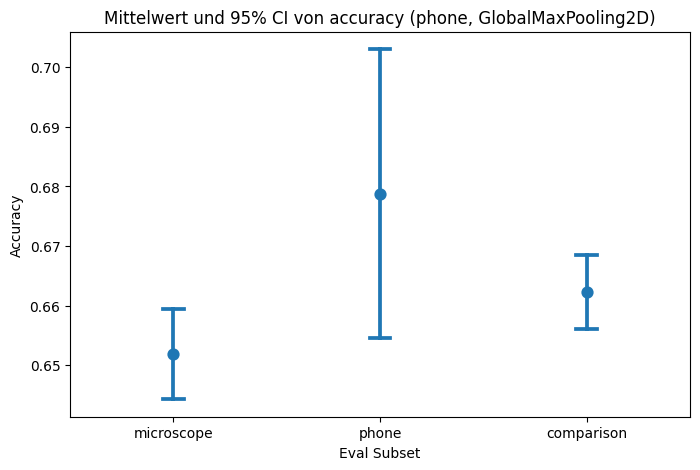

In [56]:
df_phone_max = df[
    (df["subset_name"] == "phone")
    & (df["layers"] == "GlobalMaxPooling2D")
    & (df["eval_subset"].isin(["phone", "microscope", "comparison"]))  # falls du "combined" meinst
]

# Liste der Metriken, die du anschauen willst
metrics = ["accuracy"]

# Für jede Metrik einen Plot erstellen
for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.pointplot(
        data=df_phone_max,
        x="eval_subset",
        y=metric,
        ci=95,            # 95% Konfidenzintervall
        capsize=0.1,      # kleine Querstriche am Fehlerbalken
        estimator="mean",  # Mittelwert berechnen
        join=False
    )
    plt.title(f"Mittelwert und 95% CI von {metric} (phone, GlobalMaxPooling2D)")
    plt.ylabel(metric.capitalize())
    plt.xlabel("Eval Subset")
    plt.show()

In [52]:
df_phone_dense.groupby(["eval_subset"])["accuracy"].mean(numeric_only=True)

eval_subset
comparison    0.649027
microscope    0.603797
phone         0.721212
Name: accuracy, dtype: float64

In [5]:
df.head()

,network,subset_name,eval_subset,seed,optimizer,layers,accuracy,precision,recall,f1,precision_w,recall_w,f1_w
0,EfficientNetV2B0,all,all,2,AdamW,GlobalMaxPooling2D,0.591512,0.589367,0.586980,0.586128,0.590060,0.591512,0.588757
1,EfficientNetV2B0,all,microscope,2,AdamW,GlobalMaxPooling2D,0.594937,0.595823,0.595639,0.594872,0.596267,0.594937,0.594742
2,EfficientNetV2B0,all,phone,2,AdamW,GlobalMaxPooling2D,0.626263,0.602459,0.603531,0.602927,0.628333,0.626263,0.627235
3,EfficientNetV2B0,all,fresh,2,AdamW,GlobalMaxPooling2D,0.648810,0.636765,0.636144,0.636430,0.648057,0.648810,0.648410
4,EfficientNetV2B0,all,dried,2,AdamW,GlobalMaxPooling2D,0.528090,0.527525,0.527806,0.526596,0.532607,0.528090,0.529285


In [12]:
desc = df.groupby(["subset_name", "eval_subset", "layers"]).describe()
desc.columns = ['_'.join(col).strip() for col in desc.columns.values]
desc

seed_count  seed_mean  seed_std  \
subset_name eval_subset layers                                                
all         all         GlobalMaxPooling2D         5.0        6.0  3.162278   
                        flatten_dense              5.0        6.0  3.162278   
            comparison  GlobalMaxPooling2D         5.0        6.0  3.162278   
                        flatten_dense              5.0        6.0  3.162278   
            dried       GlobalMaxPooling2D         5.0        6.0  3.162278   
...                                                ...        ...       ...   
phone       fresh       flatten_dense              5.0        6.0  3.162278   
            microscope  GlobalMaxPooling2D         5.0        6.0  3.162278   
                        flatten_dense              5.0        6.0  3.162278   
            phone       GlobalMaxPooling2D         5.0        6.0  3.162278   
                        flatten_dense              5.0        6.0  3.162278   

                                            seed_min  seed_25%  seed_50%  \
subset_name eval_subset layers                                             
all         all         GlobalMaxPooling2D       2.0       4.0       6.0   
                        flatten_dense            2.0       4.0       6.0   
            comparison  GlobalMaxPooling2D       2.0       4.0       6.0   
                        flatten_dense            2.0       4.0       6.0   
            dried       GlobalMaxPooling2D       2.0       4.0       6.0   
...                                              ...       ...       ...   
phone       fresh       flatten_dense            2.0       4.0       6.0   
            microscope  GlobalMaxPooling2D       2.0       4.0       6.0   
                        flatten_dense            2.0       4.0       6.0   
            phone       GlobalMaxPooling2D       2.0       4.0       6.0   
                        flatten_dense            2.0       4.0       6.0   

                                            seed_75%  seed_max  \
subset_name eval_subset layers                                   
all         all         GlobalMaxPooling2D       8.0      10.0   
                        flatten_dense            8.0      10.0   
            comparison  GlobalMaxPooling2D       8.0      10.0   
                        flatten_dense            8.0      10.0   
            dried       GlobalMaxPooling2D       8.0      10.0   
...                                              ...       ...   
phone       fresh       flatten_dense            8.0      10.0   
            microscope  GlobalMaxPooling2D       8.0      10.0   
                        flatten_dense            8.0      10.0   
            phone       GlobalMaxPooling2D       8.0      10.0   
                        flatten_dense            8.0      10.0   

                                            accuracy_count  accuracy_mean  \
subset_name eval_subset layers                                              
all         all         GlobalMaxPooling2D             5.0       0.628117   
                        flatten_dense                  5.0       0.732626   
            comparison  GlobalMaxPooling2D             5.0       0.653696   
                        flatten_dense                  5.0       0.754864   
            dried       GlobalMaxPooling2D             5.0       0.613483   
...                                                    ...            ...   
phone       fresh       flatten_dense                  5.0       0.684524   
            microscope  GlobalMaxPooling2D             5.0       0.651899   
                        flatten_dense                  5.0       0.603797   
            phone       GlobalMaxPooling2D             5.0       0.678788   
                        flatten_dense                  5.0       0.721212   

                                            ...  recall_w_75%  recall_w_max  \
subset_name eval_subset layers              ...                               
all     

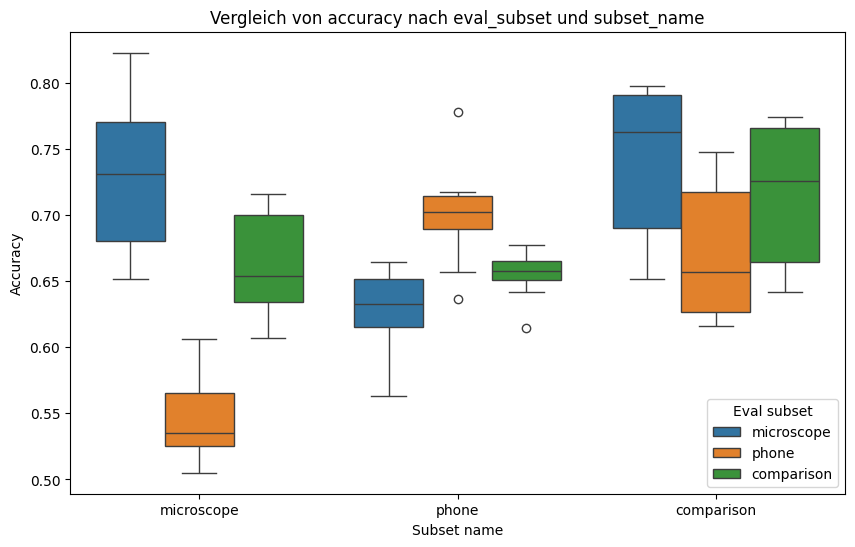

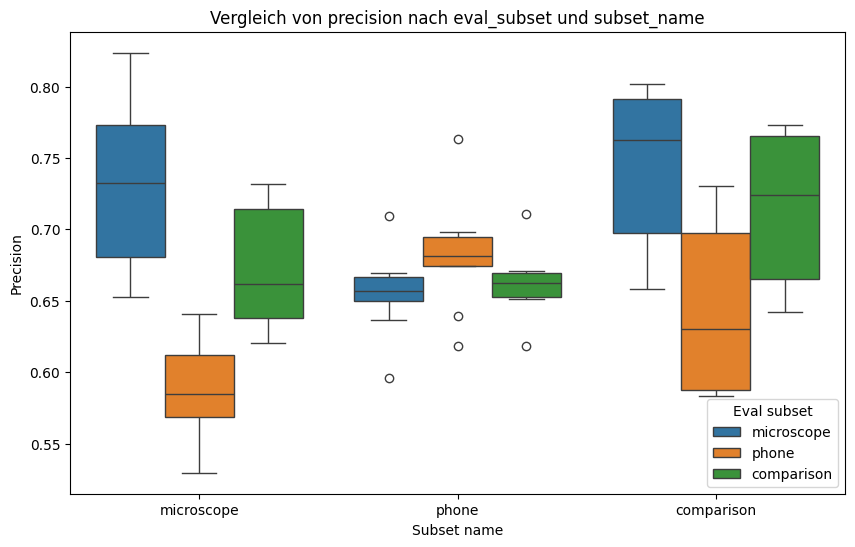

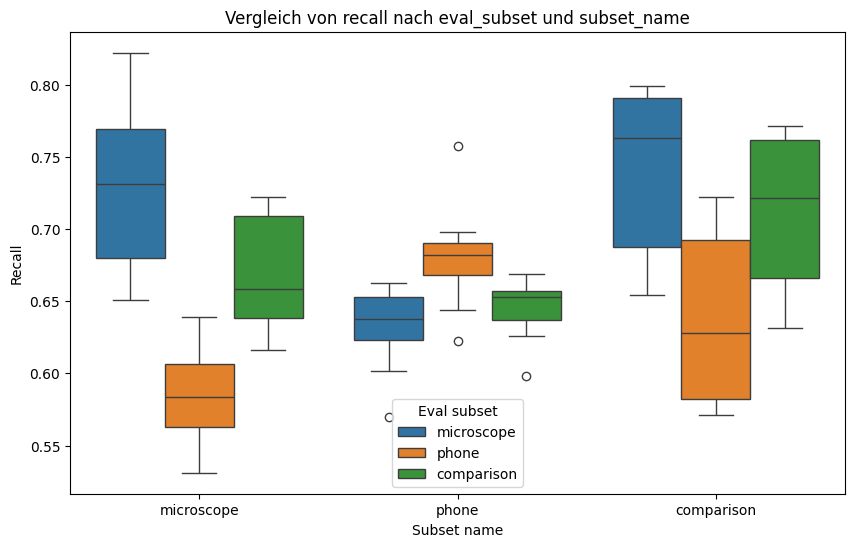

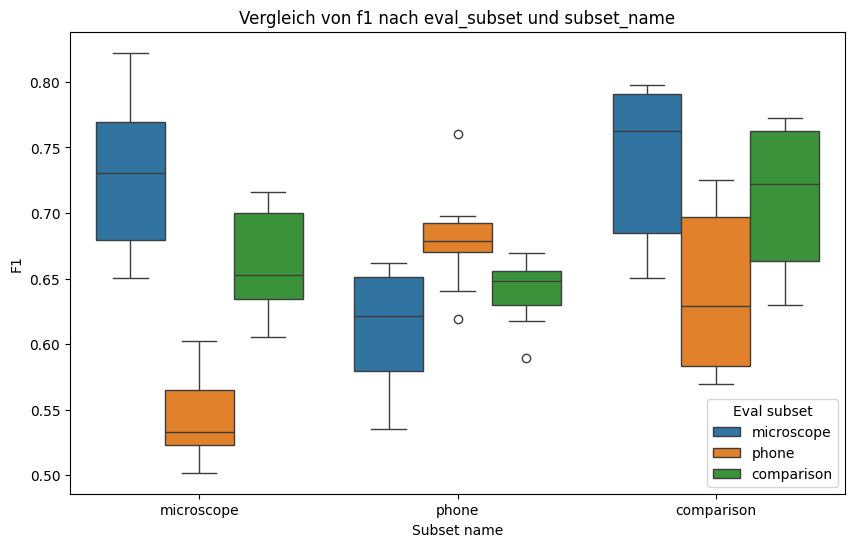

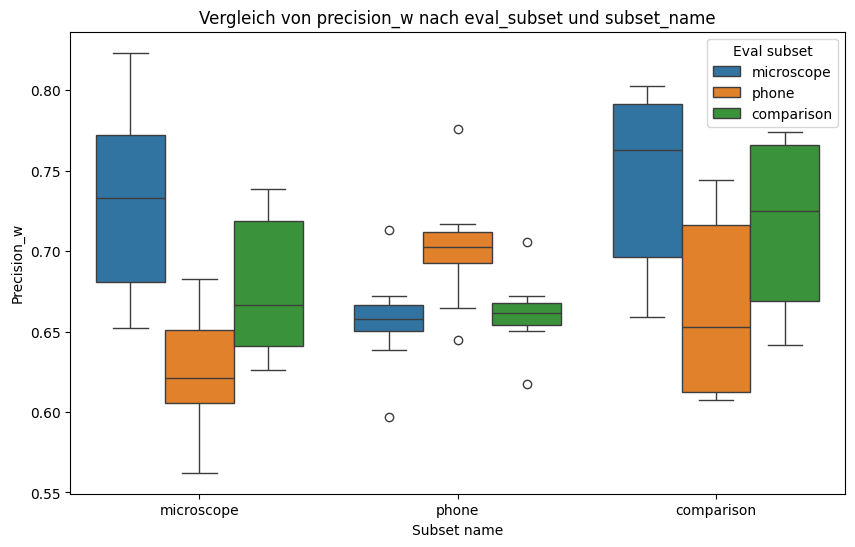

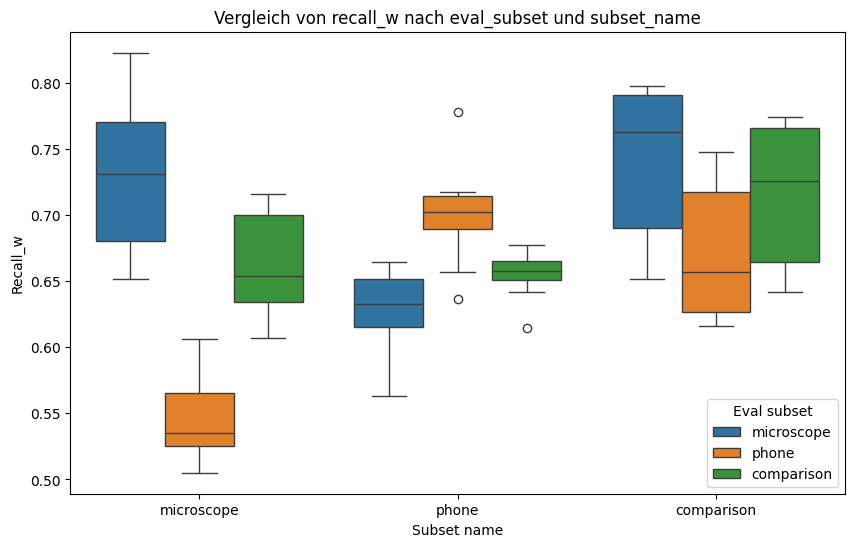

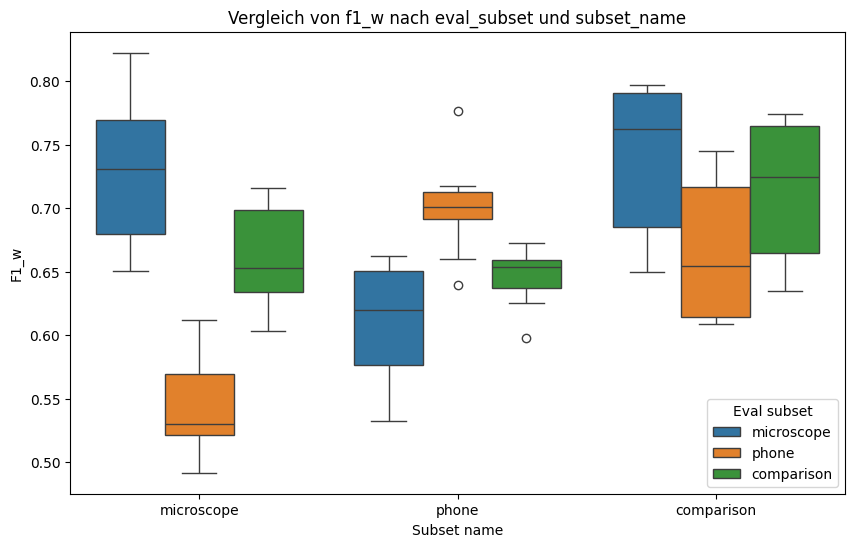

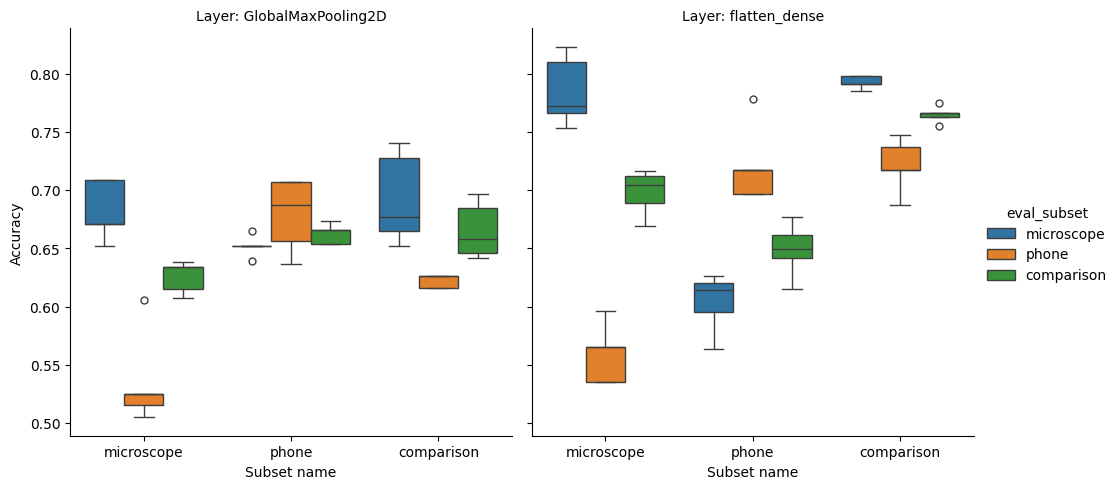

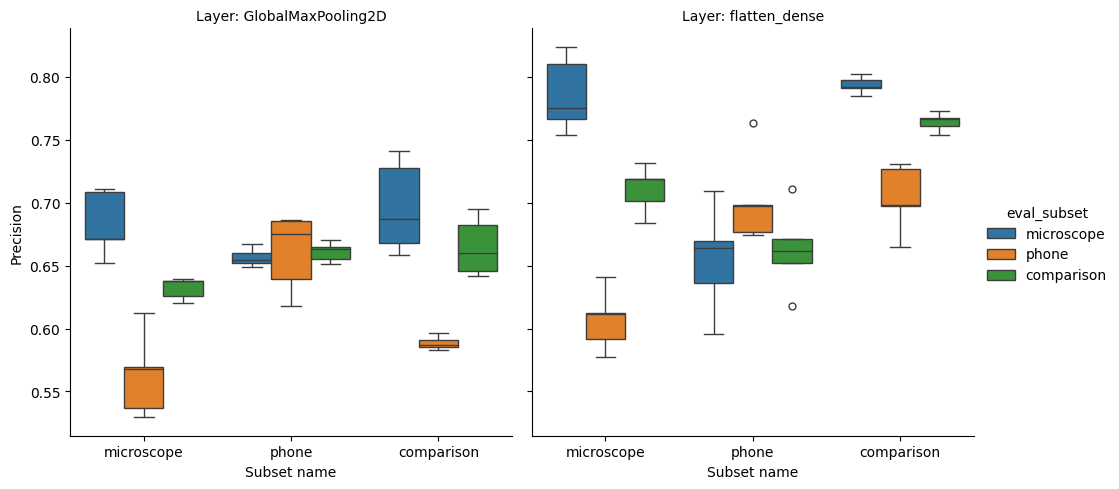

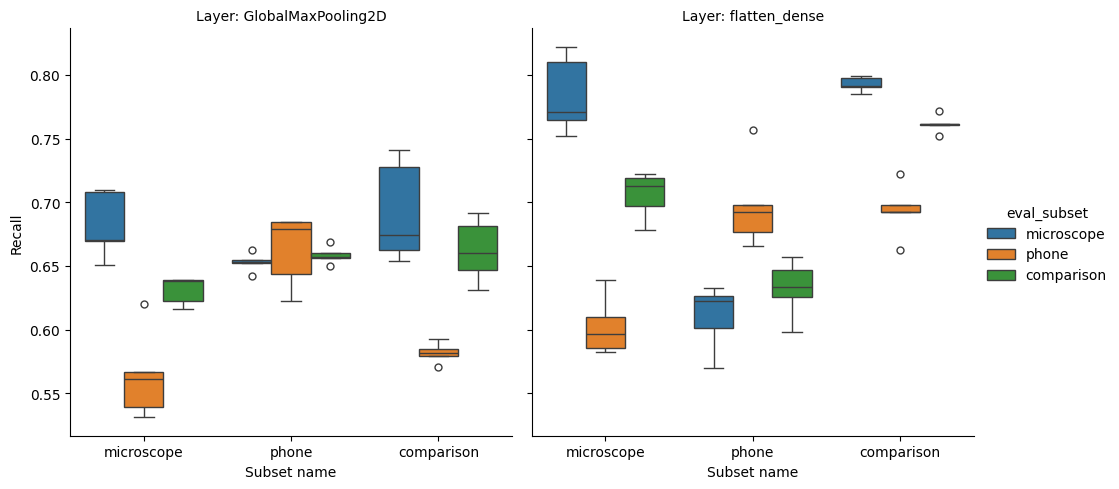

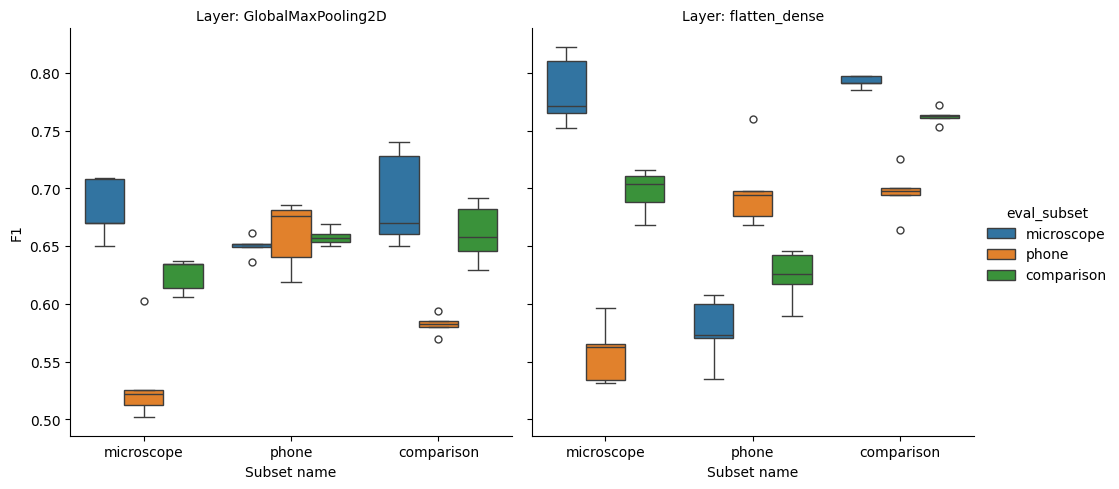

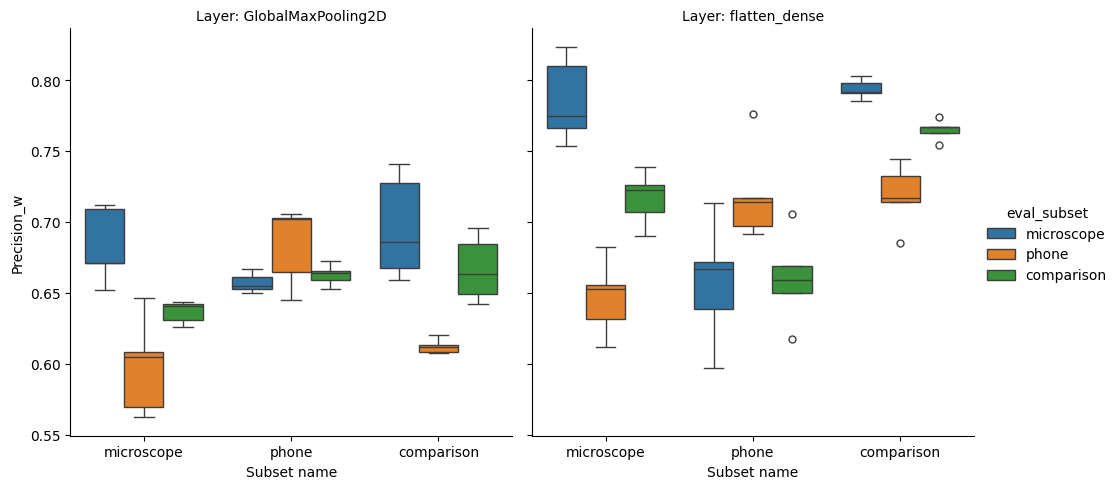

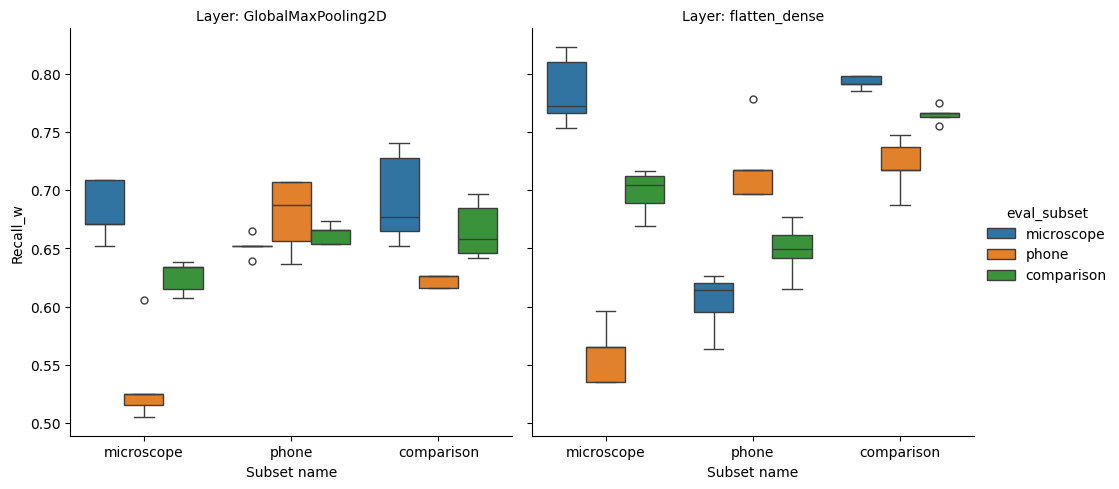

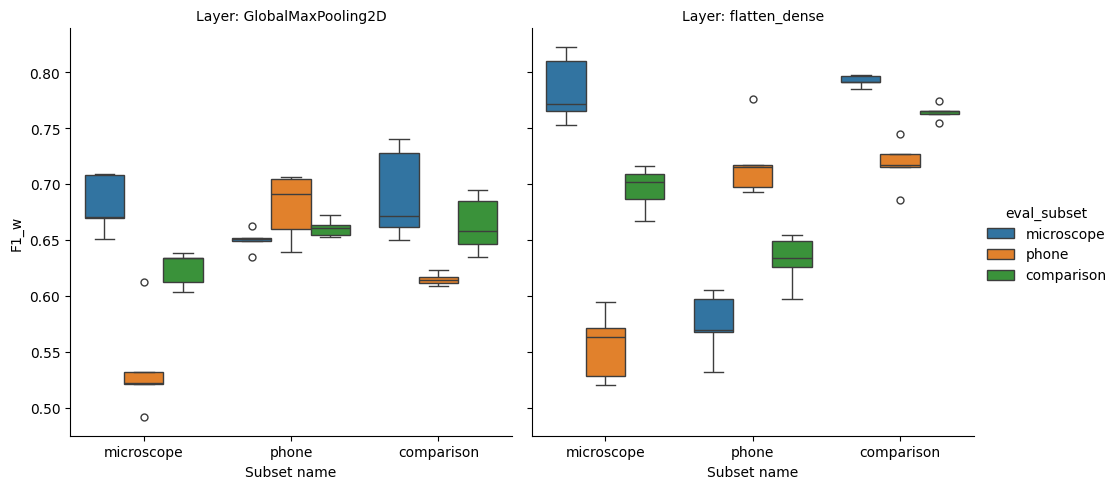

In [28]:
relevant_subsets = ["microscope", "phone", "comparison"]
relevant_evals = ["microscope", "phone", "comparison"]


filtered = df[
(df["subset_name"].isin(relevant_subsets)) &
(df["eval_subset"].isin(relevant_evals))
]


# Liste der Metriken, die du vergleichen willst
metrics = ["accuracy", "precision", "recall", "f1", "precision_w", "recall_w", "f1_w"]


# Für jede Metrik einen Boxplot erstellen
for metric in metrics:
    plt.figure(figsize=(10,6))
    sns.boxplot(
    data=filtered,
    x="subset_name", # Vergleichsgruppen
    y=metric,
    hue="eval_subset", # Unterteilung nach subset_name
    #col=None
    )
    plt.title(f"Vergleich von {metric} nach eval_subset und subset_name")
    plt.xlabel("Subset name")
    plt.ylabel(metric.capitalize())
    plt.legend(title="Eval subset")
    plt.show()


# Falls du auch layers vergleichen willst:
for metric in metrics:
    g = sns.catplot(
        data=filtered,
        kind="box",
        x="subset_name",
        y=metric,
        hue="eval_subset",
        col="layers", # Facettierung nach Layers
        height=5,
        aspect=1
    )
    g.set_axis_labels("Subset name", metric.capitalize())
    g.set_titles("Layer: {col_name}")
    plt.show()

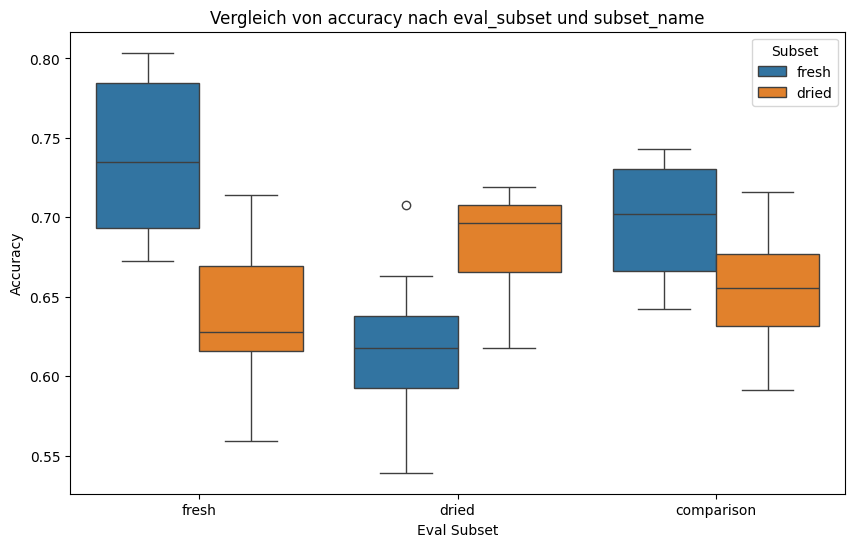

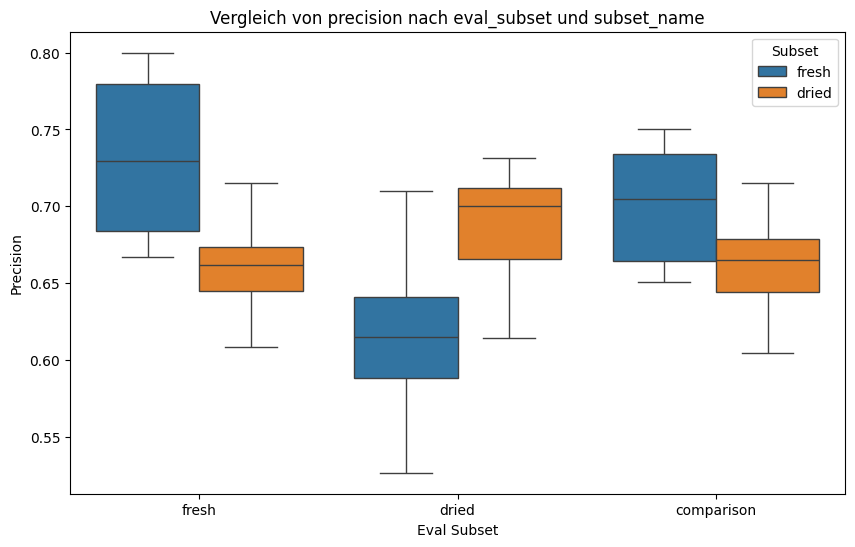

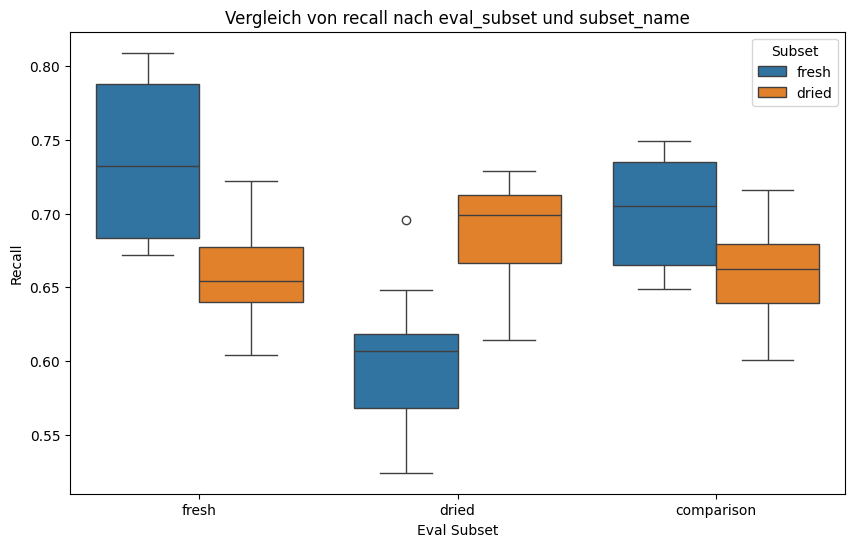

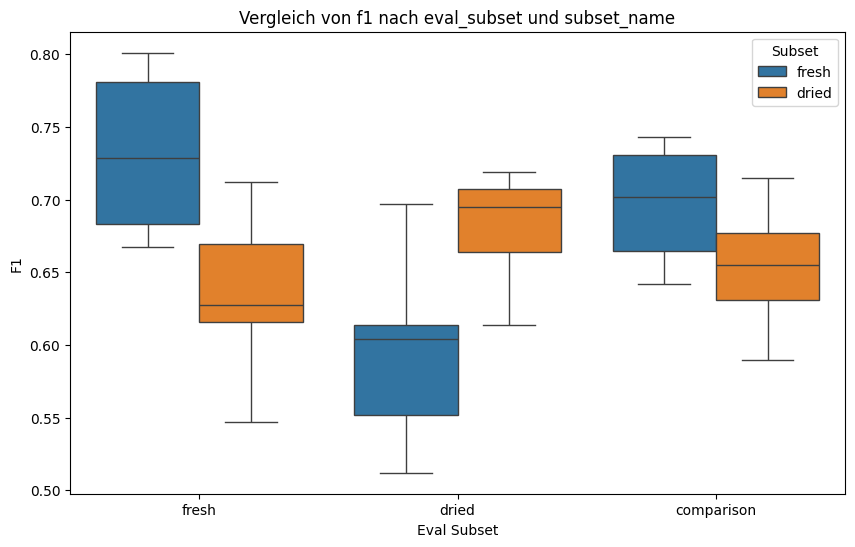

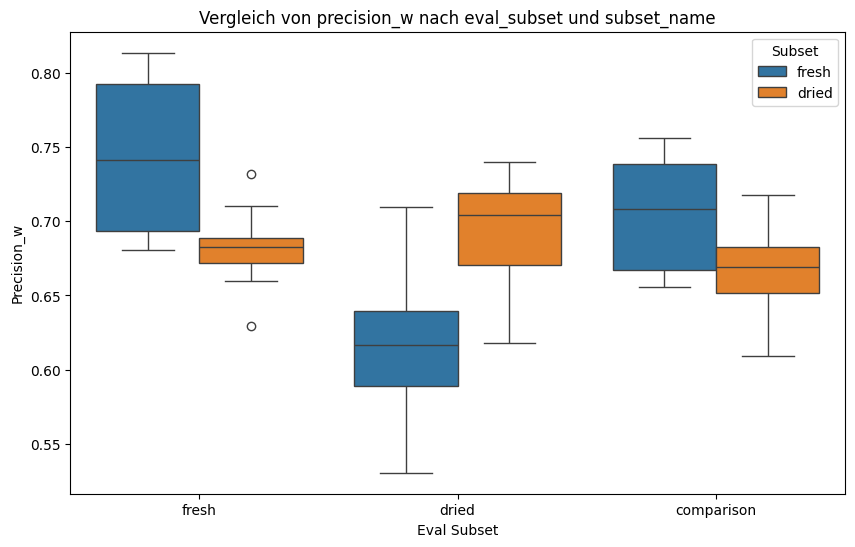

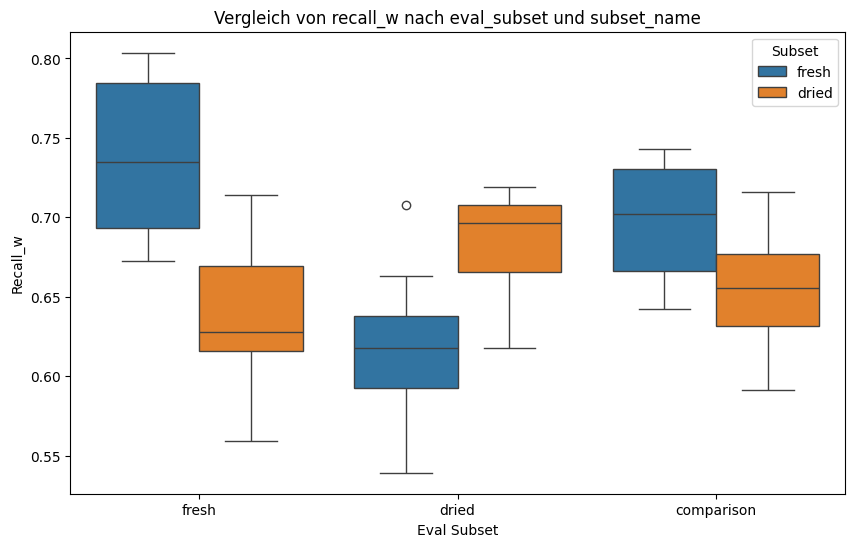

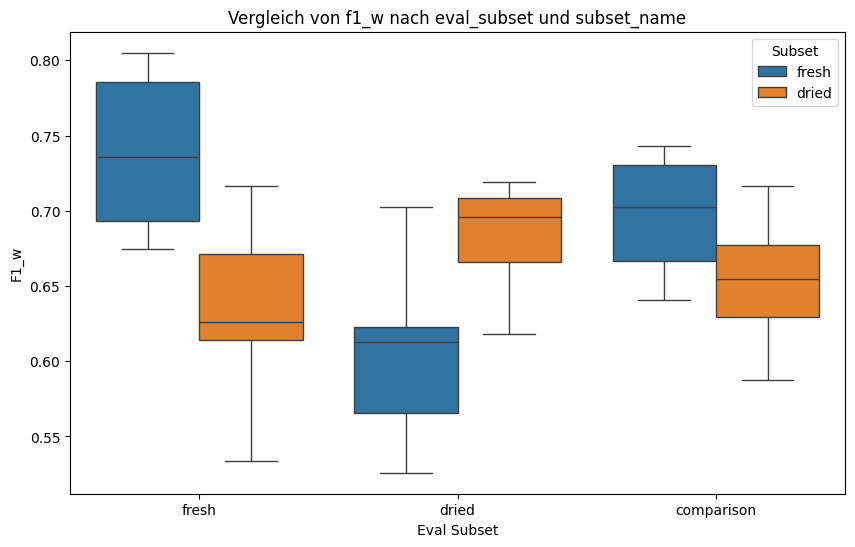

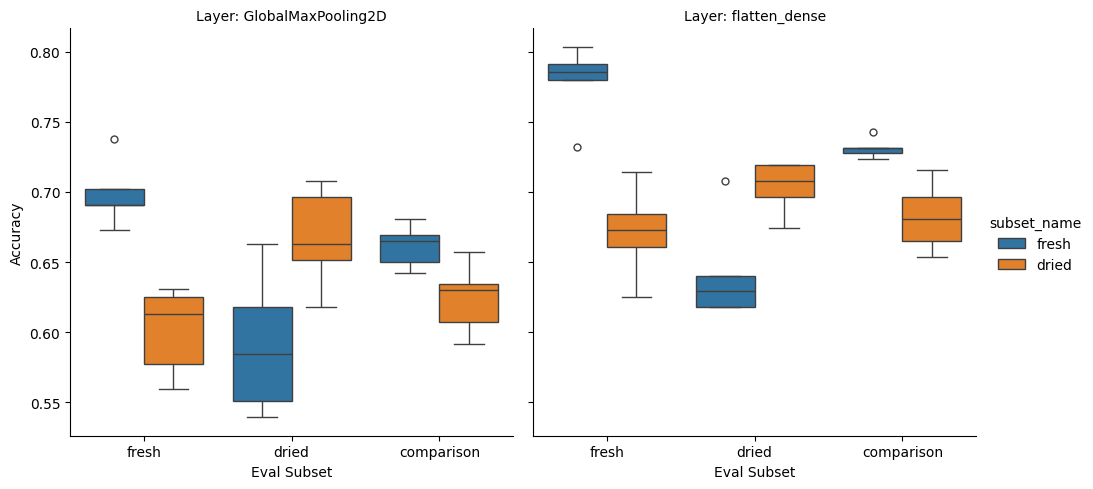

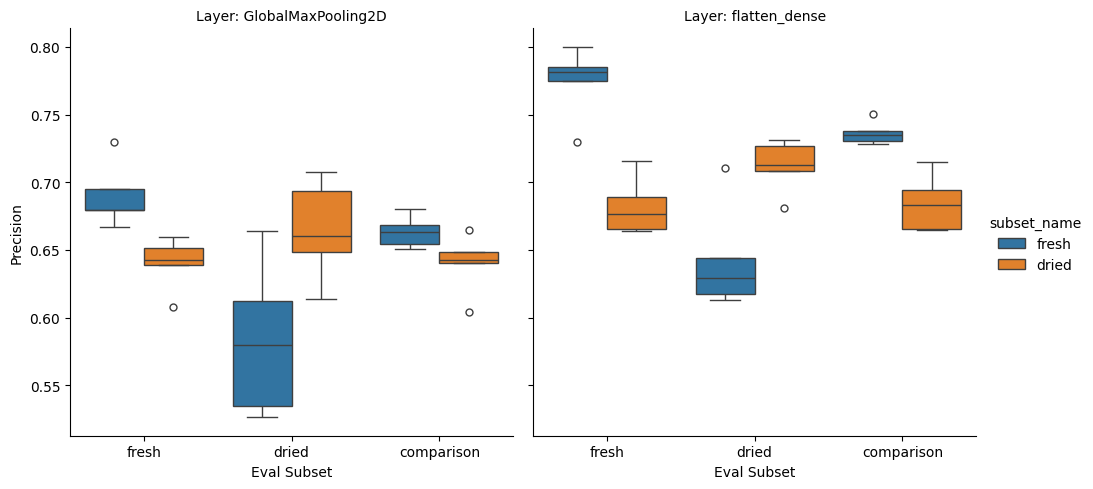

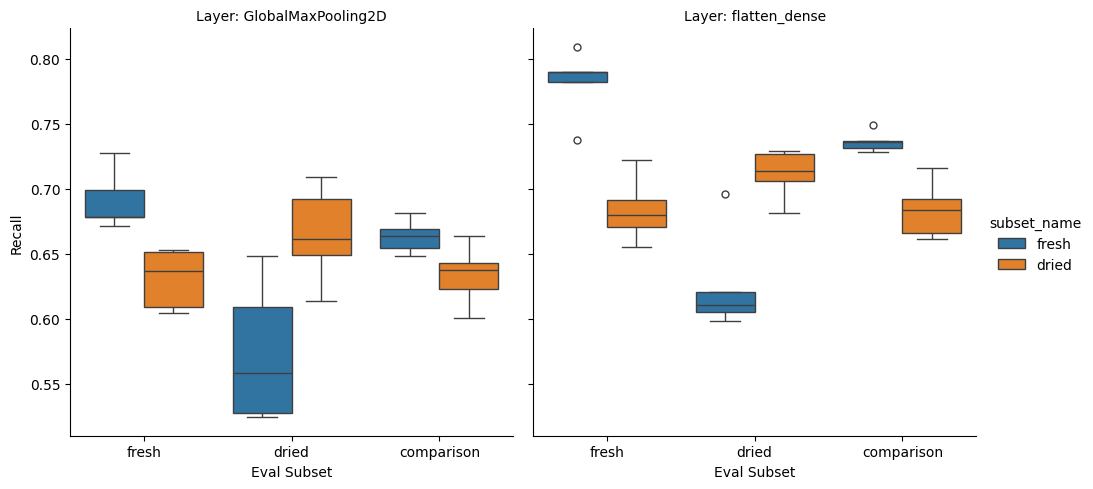

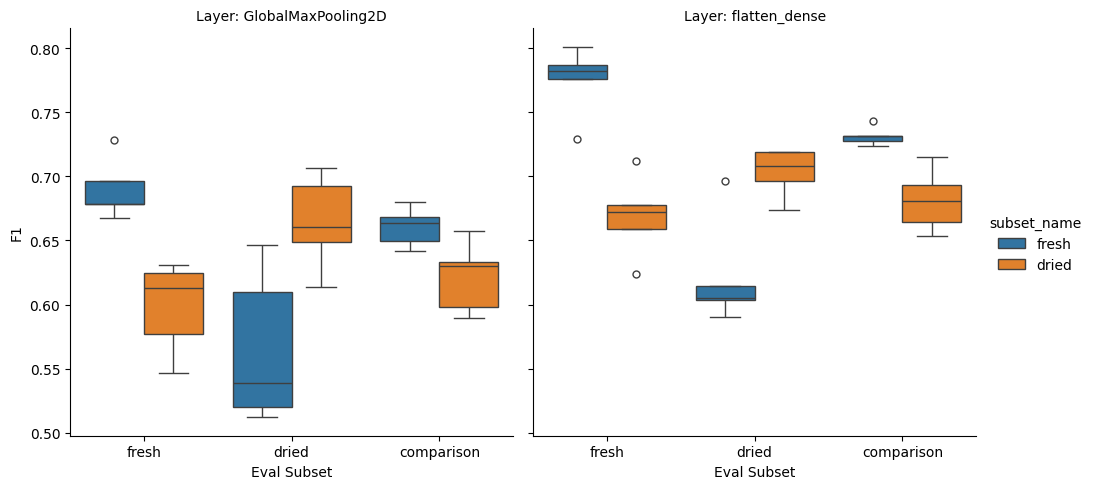

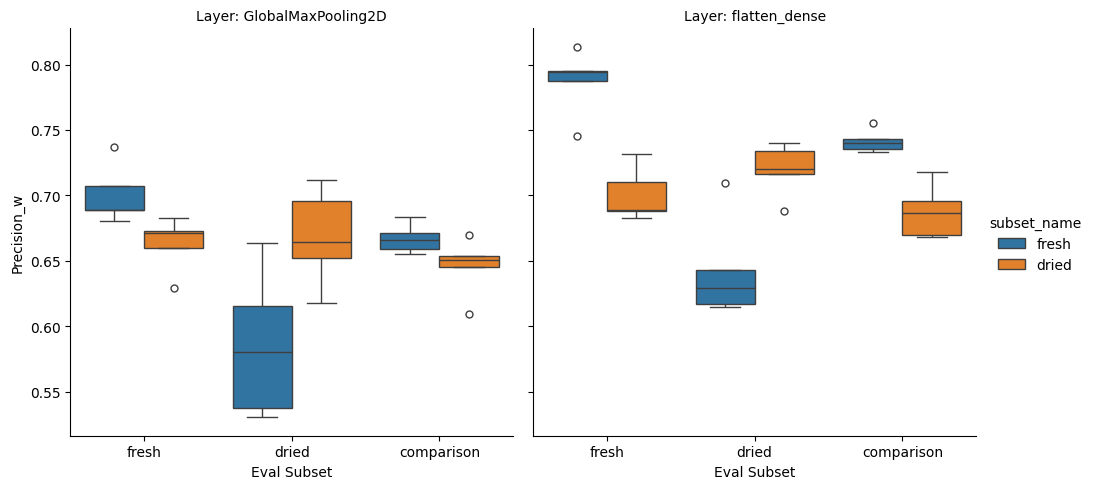

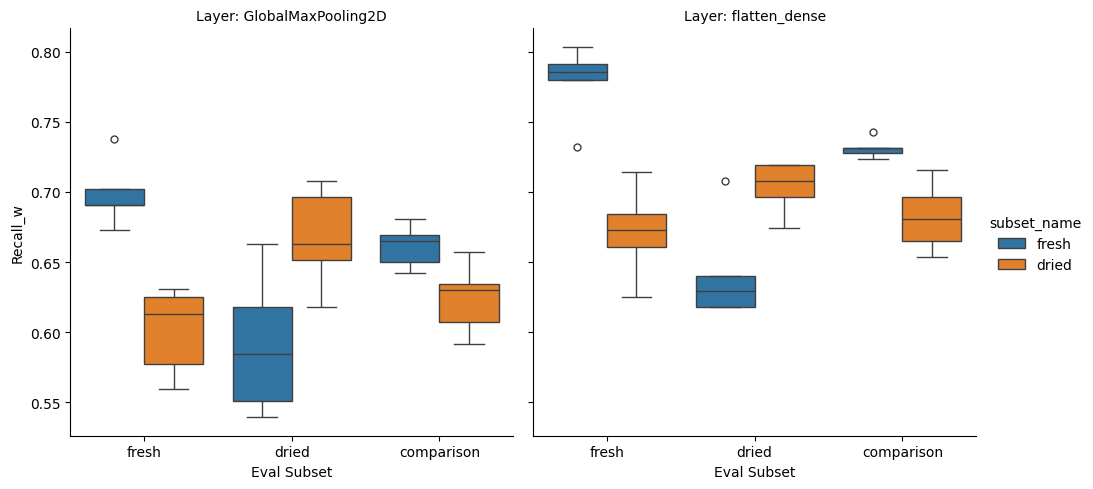

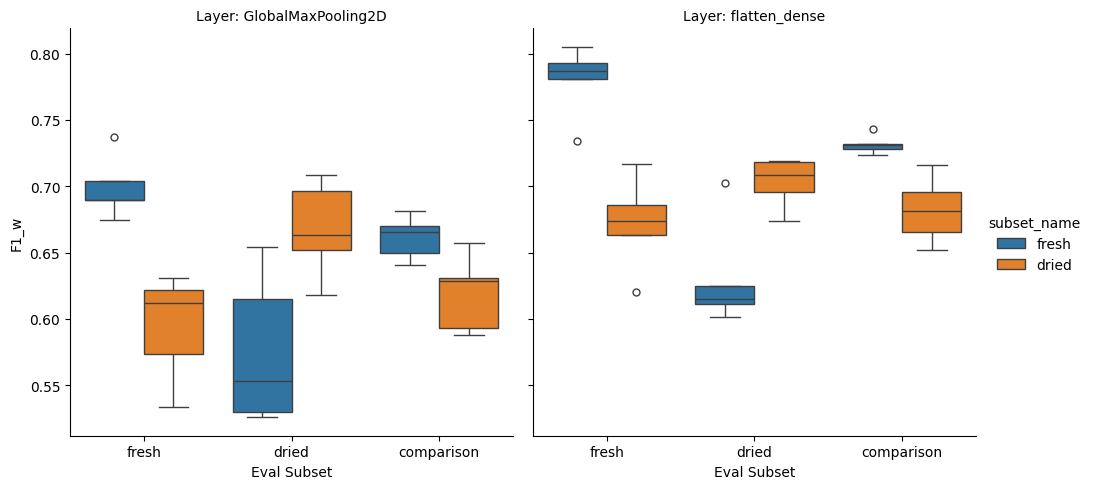

In [23]:
relevant_subsets = ["fresh", "dried"]
relevant_evals = ["fresh", "dried", "comparison"]


filtered = df[
(df["subset_name"].isin(relevant_subsets)) &
(df["eval_subset"].isin(relevant_evals))
]


# Liste der Metriken, die du vergleichen willst
metrics = ["accuracy", "precision", "recall", "f1", "precision_w", "recall_w", "f1_w"]


# Für jede Metrik einen Boxplot erstellen
for metric in metrics:
    plt.figure(figsize=(10,6))
    sns.boxplot(
    data=filtered,
    x="eval_subset", # Vergleichsgruppen
    y=metric,
    hue="subset_name", # Unterteilung nach subset_name
    #col=None
    )
    plt.title(f"Vergleich von {metric} nach eval_subset und subset_name")
    plt.xlabel("Eval Subset")
    plt.ylabel(metric.capitalize())
    plt.legend(title="Subset")
    plt.show()


# Falls du auch layers vergleichen willst:
for metric in metrics:
    g = sns.catplot(
        data=filtered,
        kind="box",
        x="eval_subset",
        y=metric,
        hue="subset_name",
        col="layers", # Facettierung nach Layers
        height=5,
        aspect=1
    )
    g.set_axis_labels("Eval Subset", metric.capitalize())
    g.set_titles("Layer: {col_name}")
    plt.show()